In [1]:
## using Pkg
## Pkg.add("PlotlyJS")

In [5]:
using DelimitedFiles
using LinearAlgebra
using Optim
using Distributions
using Test
using BenchmarkTools
using Random
using CSV
using DataFrames
using Distributed
using Plots

In [6]:
pwd()

"/Users/FredYu/Documents/GitHub/BulkLMM.jl/analysis"

In [33]:
## Include the source code of BulkLMM to be tested:
include("../src/scan.jl");
include("../src/lmm.jl");
include("../src/wls.jl");
include("../src/util.jl");
include("../src/kinship.jl");
include("../src/readData.jl");

## Also include the helper functions for writing tests:
include("../test/testHelper.jl");

In [34]:
## Read in BXD data:
pheno_file = "../data/bxdData/BXDtraits.csv"
pheno = readBXDpheno(pheno_file);
geno_file = "../data/bxdData/BXDgeno_prob.csv"
geno = readGenoProb_ExcludeComplements(geno_file);

kinship = calcKinship(geno); # calculate kinship matrix from genotype data

In [35]:
nperms = 1024; # number of permutated copies required;
m = size(pheno, 2);
p = size(geno, 2); # number of markers

heritabilities = Array{Float64, 1}(undef, m);


for j in 1:m
    heritabilities[j] = scan(reshape(pheno[:, j], :, 1), geno, kinship; reml = true)[2] 
end

histogram(heritabilities[1:7000], bins = 100)

length(heritabilities)

plot(heritabilities)

findmax(heritabilities)

In [36]:
## Consider the 7919-th trait
pheno_y = reshape(pheno[:, 7919], :, 1);

In [37]:
include("../src/scan.jl");

In [38]:
@btime scan_perms(pheno_y, geno, kinship; nperms = 100);

  884.306 ms (183989 allocations: 1.37 GiB)


In [39]:
@btime scan_perms(pheno_y, geno, kinship; nperms = 1024); # output structures of function

  7.851 s (194771 allocations: 13.63 GiB)


In [40]:
results_nperms = scan_perms(pheno_y, geno, kinship); # output structures of function

In [41]:
size(results_nperms)

(1025, 7321)

## Do the same for many traits (first 1000):

In [42]:
# Function that extracts the row maximums for a matrix:
function getMaxLod_manyTraits(pheno::Array{Float64, 2}, geno::Array{Float64, 2}, kinship::Array{Float64, 2};
                              ntraits::Int64 = 1000, nperms::Int64 = 1024, original::Bool = true)
    
    if original
        nrows = nperms+1
    else
        nrows = nperms
    end
    
    maxLods_manyTraits = Matrix{Float64}(undef, nrows, ntraits);
    
    for k in 1:ntraits
        
        pheno_k = reshape(pheno[:, k], :, 1);
        results = scan_perms(pheno_k, geno, kinship; nperms = nperms)
        
        maxLods_manyTraits[:, k] = getMaxLod(results)
    end
    
    return maxLods_manyTraits; 
end


function getMaxLod(results::Array{Float64, 2})
    
    return mapslices(x -> maximum(x), results; dims = 2);
    
end

getMaxLod (generic function with 1 method)

In [43]:
maxLods = getMaxLod(results_nperms);

In [44]:
typeof(maxLods)

Matrix{Float64} (alias for Array{Float64, 2})

In [45]:
size(maxLods)

(1025, 1)

In [46]:
quantile(maxLods[:, 1], 0.95)

3.75008800449138

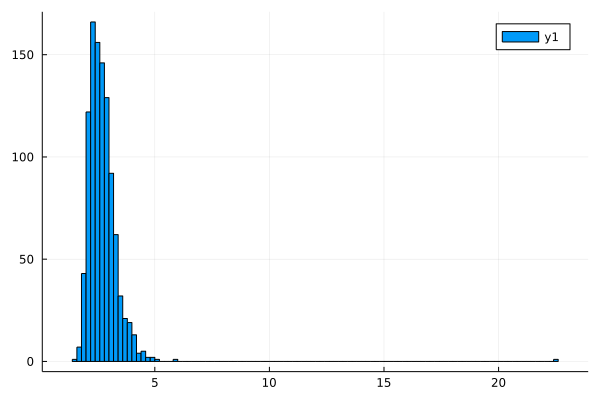

In [47]:
histogram(maxLods)

In [48]:
typeof(pheno_y)

Matrix{Float64} (alias for Array{Float64, 2})

In [49]:
@btime scan(pheno_y, geno, kinship);

  18.517 ms (101879 allocations: 34.44 MiB)


In [50]:
@btime scan_perms(pheno_y, geno, kinship; nperms = 0); # using rowDivide! with 1./sqrt(wts)

  27.926 ms (161025 allocations: 49.72 MiB)


In [51]:
@btime scan_perms(pheno_y, geno, kinship; nperms = 0); # using rowMultiply! with sqrt(wts)

  28.736 ms (161025 allocations: 49.72 MiB)


In [52]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 1, nperms = 1024);

  7.691 s (205852 allocations: 13.63 GiB)


In [53]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 100, nperms = 1);

  4.083 s (16197959 allocations: 6.18 GiB)


In [ ]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 1000, nperms = 1);

In [ ]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 100, nperms = 10);

In [ ]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 1000, nperms = 10);

In [ ]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 100, nperms = 20);

In [ ]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 1000, nperms = 20);

In [ ]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 100, nperms = 100);

In [158]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 1000, nperms = 100);

  1109.673 s (185488911 allocations: 1374.91 GiB)


In [62]:
maxLods_1000Traits = getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 1000, nperms = 100);

In [63]:
size(maxLods_1000Traits)

(101, 1000)

In [69]:
maxLods_1000Traits

101×1000 Matrix{Float64}:
 2.03725  2.86144  2.3812   3.03671  …  2.06776  3.09253  2.30333  2.91197
 2.64493  2.18224  2.6128   2.82138     2.02412  2.40514  1.80398  1.90582
 2.47166  2.45386  2.02905  1.67337     2.75327  2.36688  2.02967  2.5377
 2.16444  2.35367  2.58056  2.12896     2.53937  3.09596  2.57048  1.88669
 3.10081  1.95717  2.40188  2.11589     2.65902  1.95085  2.76738  2.61998
 2.54376  2.43402  2.27102  2.1845   …  3.07654  4.11044  2.37409  2.09005
 2.31185  3.39075  2.46014  2.08985     2.36313  3.16853  1.85882  2.14513
 2.68521  2.08347  2.98414  2.67844     2.38674  1.97647  4.45338  2.15962
 1.76336  2.30767  1.98088  2.11391     2.28722  1.70052  3.37991  2.12289
 2.64297  2.14998  1.9253   2.13167     3.17382  2.18959  2.99913  1.92127
 2.16168  1.82536  2.48665  3.01149  …  2.61163  2.05508  2.66176  2.36399
 2.81028  2.36774  2.72961  2.49401     2.37808  3.07218  2.65702  2.97004
 1.83534  2.80102  2.23917  3.06208     1.73493  3.80936  2.35848  3.25948


In [64]:
quantile_1000Traits = mapslices(x -> quantile(x, 0.95), maxLods_1000Traits; dims = 1)

1×1000 Matrix{Float64}:
 3.80872  3.4215  3.70595  3.47996  …  3.44377  3.69514  3.37991  3.91719

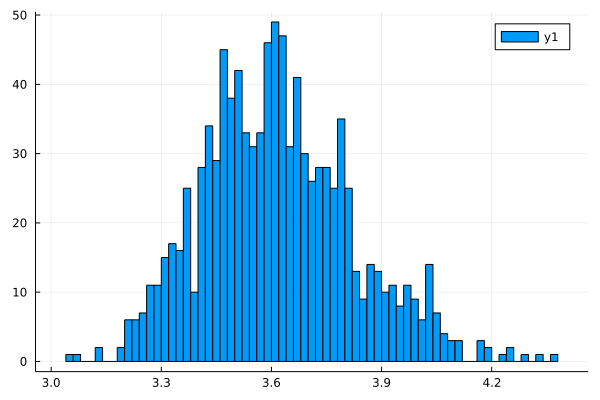

In [67]:
histogram(vec(quantile_1000Traits), bins = 100)

In [68]:
findmax(quantile_1000Traits)

(4.3743419572091184, CartesianIndex(1, 232))